# Neural Surrogate for Option Pricing — Bates Model
This notebook demonstrates a workflow for building and evaluating a neural network surrogate for option pricing under the **Bates model**, including:

- Generating synthetic option price data using the Bates stochastic volatility and jump-diffusion model.
- Training a neural network surrogate in PyTorch to approximate Bates option prices.
- Evaluating the model’s accuracy and visualizing results.
- Benchmarking inference speed against Monte Carlo pricing.


In [31]:
# =====================================================
# Neural Surrogate for Option Pricing — Bates Model
# =====================================================

# Optional: Mount Google Drive if you want to save outputs
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Download or upload your repo
# # Option 1: Upload manually
# from google.colab import files
# uploaded = files.upload()  # Upload option-surrogate.zip

# Option 2: If already in Drive
!cp "/content/drive/MyDrive/option-surrogate.zip" /content/

# Unzip the project
!unzip -o /content/option-surrogate.zip -d /content/

# Move into repo
%cd /content/option-surrogate

# Install dependencies
!pip install -r requirements.txt

Mounted at /content/drive
Archive:  /content/option-surrogate.zip
  inflating: /content/__MACOSX/._option-surrogate  
  inflating: /content/option-surrogate/.DS_Store  
  inflating: /content/__MACOSX/option-surrogate/._.DS_Store  
  inflating: /content/option-surrogate/requirements.txt  
  inflating: /content/__MACOSX/option-surrogate/._requirements.txt  
  inflating: /content/option-surrogate/README.md  
  inflating: /content/__MACOSX/option-surrogate/._README.md  
  inflating: /content/__MACOSX/option-surrogate/._configs  
  inflating: /content/__MACOSX/option-surrogate/._notebooks  
  inflating: /content/__MACOSX/option-surrogate/._src  
  inflating: /content/option-surrogate/configs/bates_config.yaml  
  inflating: /content/__MACOSX/option-surrogate/configs/._bates_config.yaml  
  inflating: /content/option-surrogate/configs/heston_config.yaml  
  inflating: /content/__MACOSX/option-surrogate/configs/._heston_config.yaml  
  inflating: /content/option-surrogate/configs/bs_config.ya

In [32]:
# ======================================
# Step 1 — Generate Bates data
# ======================================
!export PYTHONPATH=$(pwd) && python src/data_bates.py

100% 5000/5000 [04:12<00:00, 19.82it/s]
Saved Bates dataset to data_bates.npz


In [33]:
import numpy as np
data = np.load('data_bates.npz')
for k in data.files:
    print(k, data[k].shape)

S (5000,)
K (5000,)
T (5000,)
r (5000,)
v0 (5000,)
kappa (5000,)
theta (5000,)
sigma_v (5000,)
rho (5000,)
lam (5000,)
mu_j (5000,)
sigma_j (5000,)
price (5000,)


In [34]:
# ======================================
# Step 2 — Train the surrogate model
# ======================================
!export PYTHONPATH=$(pwd) && python src/train.py --dataset bates

Epoch 1/200, Loss: 930.641646
Epoch 2/200, Loss: 927.707512
Epoch 3/200, Loss: 924.611470
Epoch 4/200, Loss: 920.966225
Epoch 5/200, Loss: 916.464237
Epoch 6/200, Loss: 910.715616
Epoch 7/200, Loss: 903.419907
Epoch 8/200, Loss: 894.215680
Epoch 9/200, Loss: 882.493196
Epoch 10/200, Loss: 868.243349
Epoch 11/200, Loss: 850.865942
Epoch 12/200, Loss: 829.740130
Epoch 13/200, Loss: 804.514859
Epoch 14/200, Loss: 774.729887
Epoch 15/200, Loss: 740.100565
Epoch 16/200, Loss: 699.988087
Epoch 17/200, Loss: 654.936362
Epoch 18/200, Loss: 604.727692
Epoch 19/200, Loss: 549.700895
Epoch 20/200, Loss: 490.911608
Epoch 21/200, Loss: 430.669394
Epoch 22/200, Loss: 369.690992
Epoch 23/200, Loss: 312.417106
Epoch 24/200, Loss: 262.445139
Epoch 25/200, Loss: 223.776755
Epoch 26/200, Loss: 196.384236
Epoch 27/200, Loss: 181.087059
Epoch 28/200, Loss: 171.625307
Epoch 29/200, Loss: 162.559760
Epoch 30/200, Loss: 149.060823
Epoch 31/200, Loss: 132.371439
Epoch 32/200, Loss: 116.797747
Epoch 33/200, Los

In [39]:
# ======================================
# Step 3 — Evaluate and Visualize
# ======================================
!export PYTHONPATH=$(pwd) && python src/eval.py --dataset bates

MSE: 4.3445e+00
MAE: 1.5529e+00
Figure(600x600)
Figure(600x400)


MSE: 4.3445e+00
MAE: 1.5529e+00


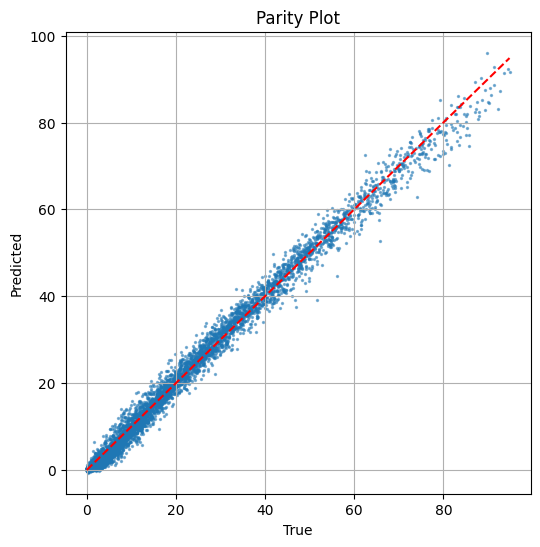

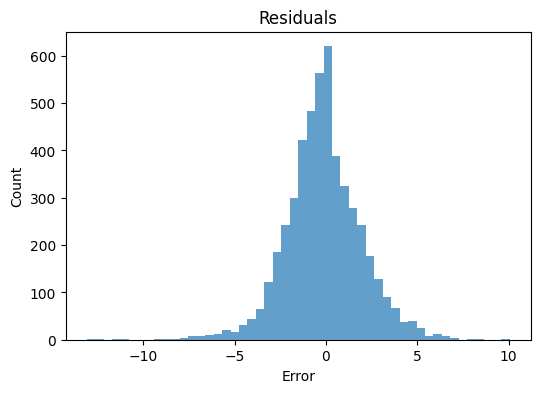

In [40]:
# ======================================
# Step 4 — Inline Evaluation and Visualization in Colab
# ======================================

import numpy as np
import torch
import matplotlib.pyplot as plt
from src.models import SurrogateMLP
from src.utils import plot_parity, plot_residuals, mse, mae

# Load dataset
data = np.load('data_bates.npz')
X = np.column_stack([data[k] for k in data.keys() if k != 'price'])
y_true = data['price']
X_scaled = (X - X.mean(0)) / X.std(0)
X_scaled_torch = torch.tensor(X_scaled, dtype=torch.float32)

# Load model
model = SurrogateMLP(X.shape[1])
model.load_state_dict(torch.load('model_bates.pt', map_location='cpu'))
model.eval()

with torch.no_grad():
    y_pred = model(X_scaled_torch).numpy()

print(f"MSE: {mse(y_true, y_pred):.4e}")
print(f"MAE: {mae(y_true, y_pred):.4e}")

plt.figure(figsize=(6,6))
plt.scatter(y_true, y_pred, s=2, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Parity Plot")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,4))
plt.hist(y_pred - y_true, bins=50, alpha=0.7)
plt.title("Residuals")
plt.xlabel("Error")
plt.ylabel("Count")
plt.show()


In [ ]:
# ======================================
# Step 5 — Inference Speed Benchmark
# ======================================
import time
from src.data_bates import bates_mc_price  # Monte Carlo pricing function

# --- Load dataset ---
data = np.load("data_bates.npz")
S = data["S"]
K = data["K"]
T = data["T"]
r = data["r"]
v0 = data["v0"]
kappa = data["kappa"]
theta = data["theta"]
sigma_v = data["sigma_v"]
rho = data["rho"]
lam = data["lam"]
mu_j = data["mu_j"]
sigma_j = data["sigma_j"]

n_eval = 500
idx = np.random.choice(len(S), n_eval, replace=False)

# --- Monte Carlo pricing baseline ---
start = time.time()
prices_mc = np.array([
    bates_mc_price(
        S[i], K[i], T[i], r[i], v0[i], kappa[i],
        theta[i], sigma_v[i], rho[i], lam[i], mu_j[i], sigma_j[i]
    )
    for i in idx
])
t_mc = time.time() - start

print(f"MC time for {n_eval} samples: {t_mc:.3f}s")
print(f"Throughput: {n_eval / t_mc:.0f} prices/sec")
print("-"*20)

#---- Trained neural surrogate ----
X_sample = torch.tensor(X_scaled[idx], dtype=torch.float32)

start = time.time()
with torch.no_grad():
    _ = model(X_sample)
t_neural = time.time() - start

print(f"Neural surrogate inference time for {n_eval} samples: {t_neural:.3f}s")
print(f"Throughput: {n_eval / t_neural:.0f} prices/sec")

MC time for 500 samples: 15.208s
Throughput: 33 prices/sec
--------------------
Neural surrogate inference time for 500 samples: 0.003s
Throughput: 189582 prices/sec
